![ISEL](logoIsel.png)

**<center style="color:#963727">Licenciatura em Engenharia Informática e Multimédia</center>**
***
## <center>PIV - Processamento de Imagem e Visão 2022/2023</center>
### <center>Trabalho Prático 1 - Contagem e Classificação de Moedas</center>
**<center>46254 Joana Pereira, 48616 Hugo Ferreira</center>**

***

<a id='section0'></a>
### **ÍNDICE:**

1. [Leitura de imagens](#section1)
2. [Conversão para níveis de cinzento](#section2)
3. [Binarização (cálculo automático de limiar)](#section3)
4. [Melhoramento da imagem](#section4)
5. [Extração de componentes conexos](#section5)
6. [Definição de caracteristicas](#section6)
7. [Extração de propriadades](#section7)
9. [Resultados](#section8)
10. [Bibliografia](#section9)
11. [Zona de testes adicionais para o docente](#section10) <---
    - [testar uma única imagem](#testar1)
    - [testar várias imagens](#testarVarias)

In [2]:
# import das bibliotecas necessárias
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

<a id='section1'></a>
### Leitura de imagens
[indice](#section0) [next](#section2)

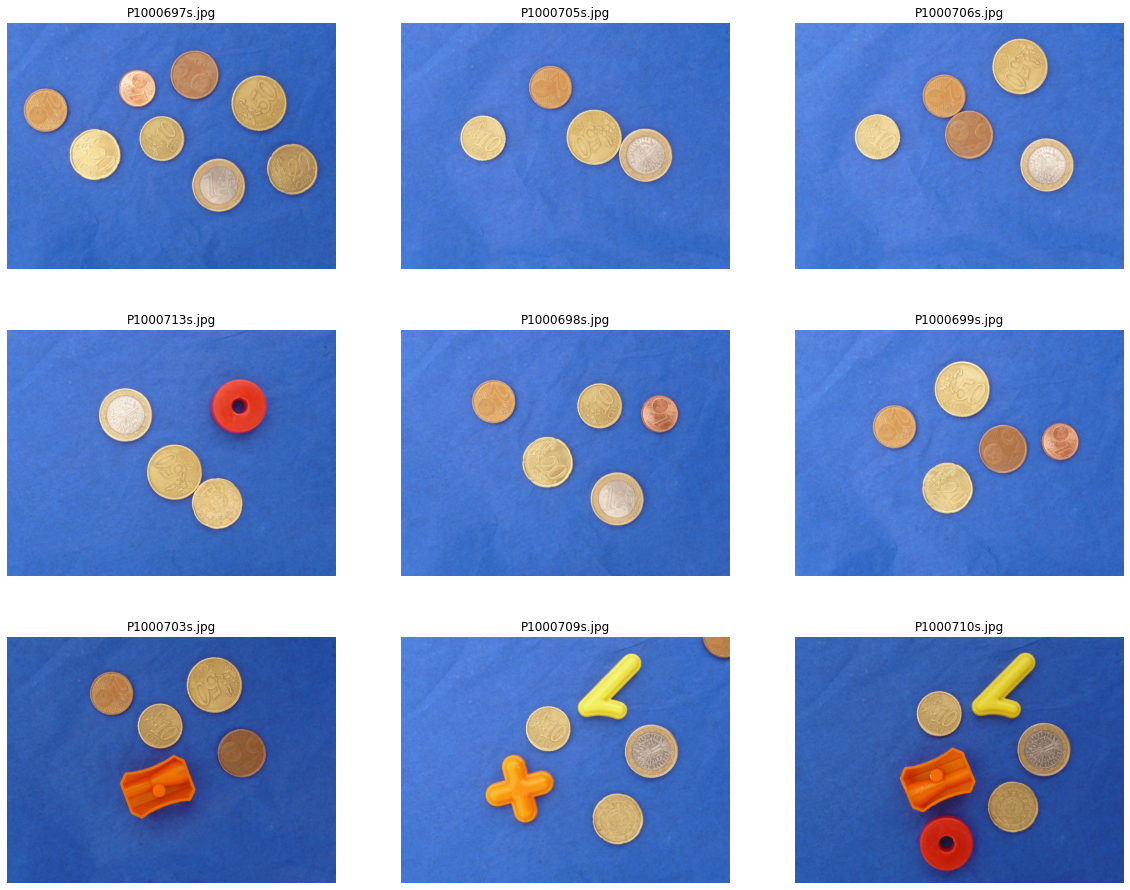

In [43]:
# Array onde se encontram os nomes de todos das imagens que vão ser usados 
# para efeitos de treino do classificador.
imagensNomes = [
    "P1000697s.jpg",
    "P1000705s.jpg",
    "P1000706s.jpg",
    "P1000713s.jpg",
    "P1000698s.jpg",
    "P1000699s.jpg",
    "P1000703s.jpg",
    "P1000709s.jpg",
    "P1000710s.jpg"
]

# Array onde se encontram os arrays das imagens
imagens = []
plt.figure(figsize=(20,16))
for i, nome in enumerate(imagensNomes):
    img = cv2.imread(nome)
    imagens.append(img)
    plt.subplot(3,3,i+1), plt.title(nome)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.axis('off')

<a id='section2'></a>
### Conversão para níveis de cinzento
[indice](#section0) [prev](#section1) [next](#section3)

» IMAGEM: P1000713s.jpg


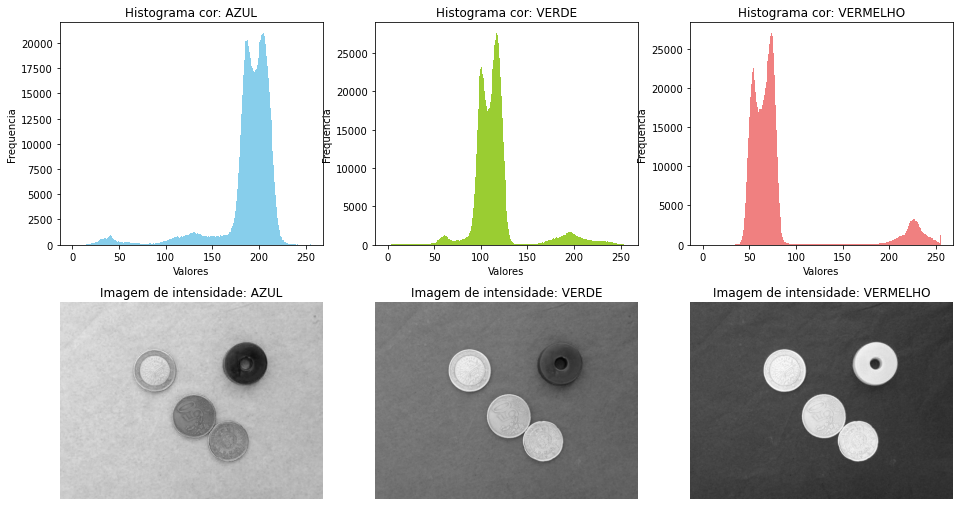

» IMAGEM: P1000710s.jpg


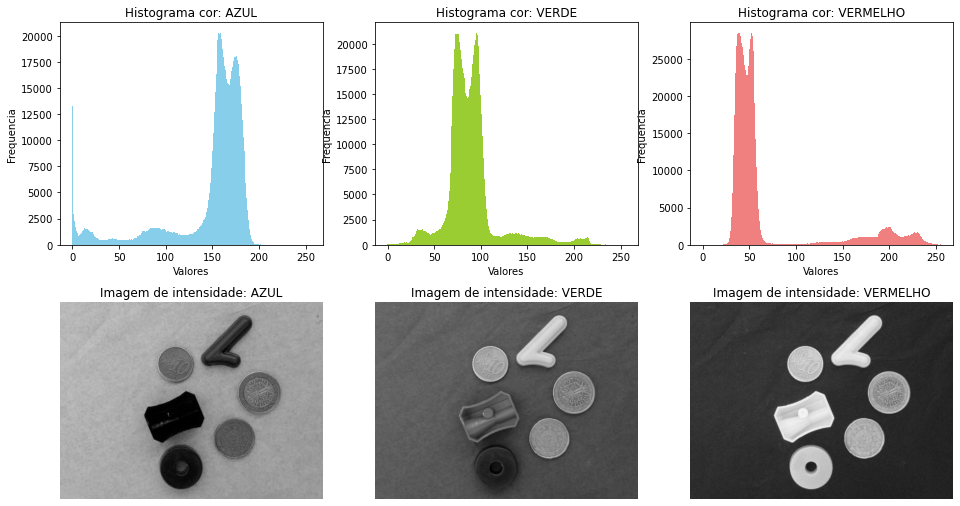

In [44]:
# Cores dos canais de cor a serem testados
coresN=['AZUL','VERDE','VERMELHO']

# Cores a aplicar na fase de mostrar os plots
coresC=['skyblue','yellowgreen','lightcoral']

# As imagens são uint8, pelo que vão ter valores de 0-255, assim é feito um
# arange de modo a fazer o plot para cada valor de cada canal.
vals=np.arange(0,256)

# Função que faz o plot de cada canal de cor para uma imagem.
# Adicionalmente mostra a imagem resultante da força desses canais de cor.
def verCanaisCorImagem(imagem):
    
    print('» IMAGEM: {}'.format(imagem))
    img = cv2.imread(imagem)
    
    plt.figure(figsize=(16,9))
    
    for i, cor in enumerate(coresN):
        
        plt.subplot(2,3,i+1)
        
        # calcular histograma: contagens de dados, neste caso das cores
        # recebe leitura da imagem (array), e para cada cor faz o plot
        # das ocorrencias de cor para cada um dos 255 valores correspondentes
        histograma = cv2.calcHist([img],[i],None,[256],[0,256]).flatten()
        
        # mostrar histograma
        plt.bar(vals,histograma, color=coresC[i], width=1)
        plt.title('Histograma cor: {}'.format(cor))
        plt.xlabel('Valores'), plt.ylabel('Frequencia')
        
        # mostrar imagem apenas com componente de cor calculada
        # Para calcular a intensidade da cor, teve de se isolar os canais de cor,
        # o que quer dizer que para cada uma das cores (3 no total), pode ser 
        # gerada uma imagem da intensidade da cor. Esta imagem vai ser a tons de
        # preto e branco, sendo que apenas um dos canais se encontra com valores
        # diferentes de 0.
        plt.subplot(2,3,i+4)
        plt.title('Imagem de intensidade: {}'.format(cor))
        plt.imshow(cv2.cvtColor(img[:,:,i], cv2.COLOR_BGR2RGB)), plt.axis('off')
    plt.show()
    
# para as imagens escolhidas, mostrar os histogramas e intensidades
for i in ['P1000713s.jpg','P1000710s.jpg']:
    verCanaisCorImagem(i)

In [46]:
# funçao meramente auxiliar para fazer plot das imagens em rgb
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

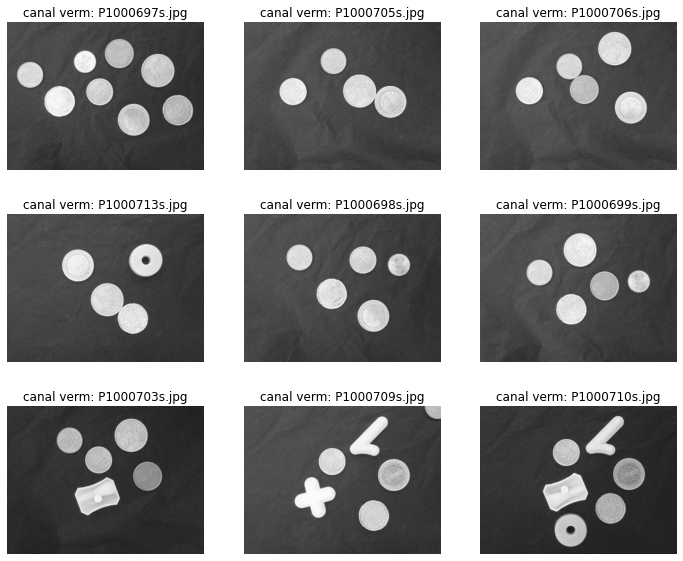

In [55]:
# ver cada canal de intensidade vermelha de cada imagem
plt.figure(figsize=(12,10))
for i, img in enumerate(imagens):
    plt.subplot(3,3,i+1), plt.title(f'canal verm: {imagensNomes[i]}')
    plt.imshow(bgr2rgb(img[:,:,2])), plt.axis('off')

<a id='section3'></a>
### Binarização (cálculo automático de limiar)
[indice](#section0) [prev](#section2) [next](#section4)

Na conversão de níveis cinzentos feita [previamente](#section2) testámos a conversão dos três canais BGR (azul, verde, vermelho) para uma imagem em tons de cinzento. Ao analisarmos os resultados concluímos que a melhor escolha para o canal a ser utilizado seria o canal de intensidade **vermelha**, sendo que a imagem criada por via da intensidade deste canal (em tons cinza), obteve um melhor contraste entre o <u>fundo</u> e os <u>objetos</u>, ou seja, esta seria a melhor maneira de converter a imagem original numa imagem em tons de cinzentos. \
O facto das moedas estarem mais visíveis com os tons de vermelho para cinzento deve-se ao facto das moedas conterem uma componente mais alta de vermelho quando comparadas ao resto da imagem, sendo que o fundo é azul. Isto justifica que apareçam como sendo mais brancas/intensas em relação ao fundo.

Após acinzentar a imagem, partimos então para a binarização da imagem usando o método *cv2.threshold* com base na intensidade dos pixeis. Este processo deve receber uma imagem em tons de cinzento, justificando a procura do melhor canal de cor para este efeito. O resultado esperado deve ser uma imagem binária, onde apenas se notam os contornos das moedas, e restantes objetos. \
Este processo compara a intensidade de um pixel, que vai ser marcado como branco (objeto) ou a preto (fundo), conforme o threshold escolhido - se for mais intenso que o valor é branco, se for menos intenso é preto. A este passo chamamos o *pre-processamento*.

O limiar usado foi o limar de **Otsu** que consiste no valor com a menor variância em todos os valores (256 valores).

A escolha deste limiar tornou-se óbvia, sendo que a utilização deste método  evita que se tenha de escolher valor limite manualmente, determinando-o automaticamente. Este método determina o <u>limiar global ótimo</u> a partir de um histograma da imagem, procurando-o entre dois picos para que a variância entre ambos seja mínima. Este valor limite é retornado como o primeiro *output* da utilização do método mencionado (variavel *otsu_threshold*). De todos os teste realizados, este foi o threshold que [melhores resultados produziu](#testesTh).

<a id='testesTh'></a>

» P1000705s.jpg


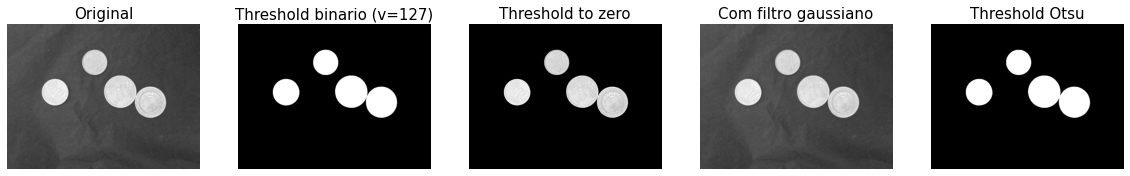

» P1000709s.jpg


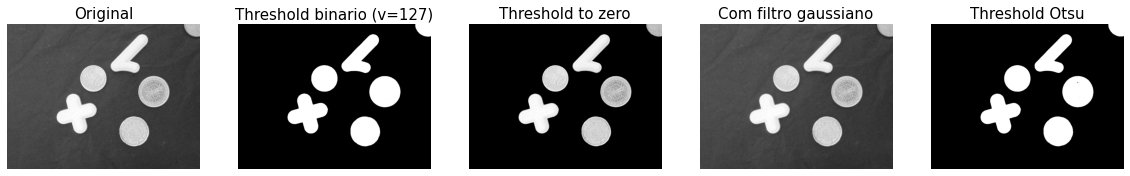

» P1000710s.jpg


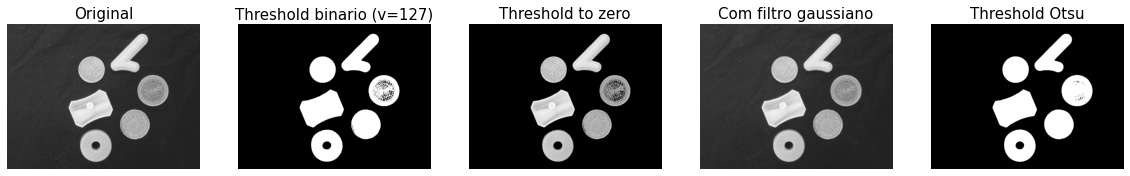

In [37]:
# imagens a ser testadas
thresholdTests = ['P1000705s.jpg','P1000709s.jpg','P1000710s.jpg']

# Para cada imagem de teste:
# 1. Isolar o canal de cor vermelhor (com as imagens em bgr, é o 3º canal, indice 2)
# 2. Testar threshold binario
# 3. Testar threshold binario
# 4. mostrar todos os resultados para avalição
for i in thresholdTests:
    img = cv2.imread(i)[:,:,2] # [:,:,2] para isolar o canal de cor vermelho
    
    # threshold binario = 127
    ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    
    # Otsu threshold = 127
    ret2,th2 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
    
    # Otsu threshold depois de filtro Gaussiano
    blur = cv2.GaussianBlur(img,(5,5),0) # kernel 5x5 para questões de teste
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_OTSU)
    
    # plot de todas as imagems + os eus histogramas
    imgs = [img, th1, th2, blur,th3]
    titulos = ['Original','Threshold binario (v=127)', 'Threshold to zero',
              'Com filtro gaussiano','Threshold Otsu']
    
    plt.figure(figsize=(20,4))
    print(f'» {i}')
    for i in range(5):
        plt.subplot(1,5,i+1),plt.imshow(bgr2rgb(imgs[i]))
        plt.title(titulos[i], fontsize=15), plt.axis('off')
    plt.show()

P1000705s.jpg


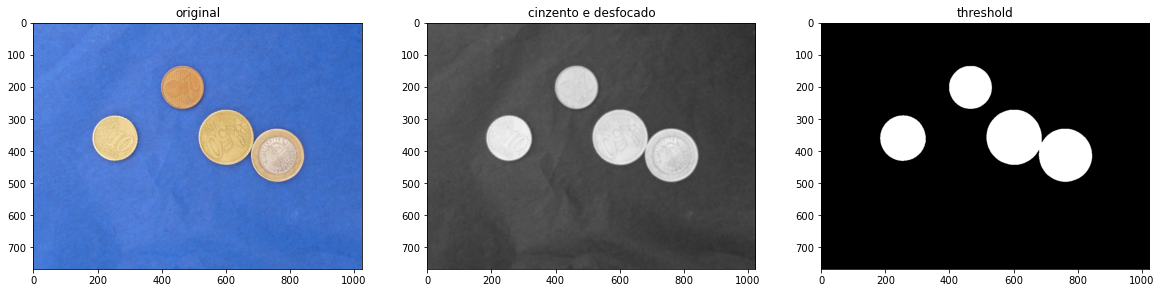

P1000709s.jpg


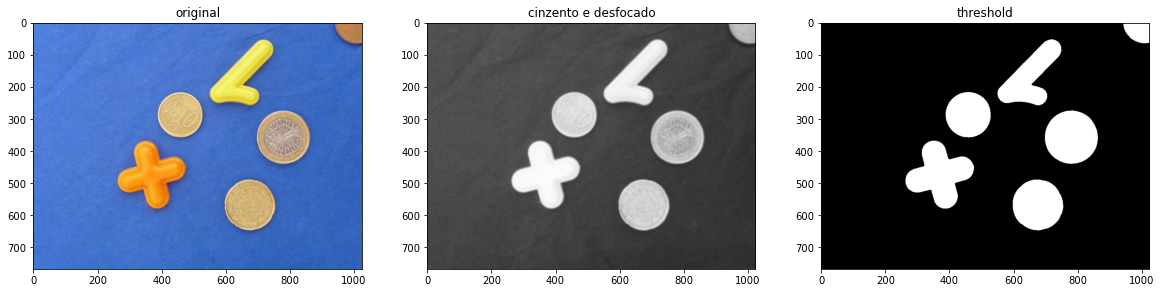

P1000710s.jpg


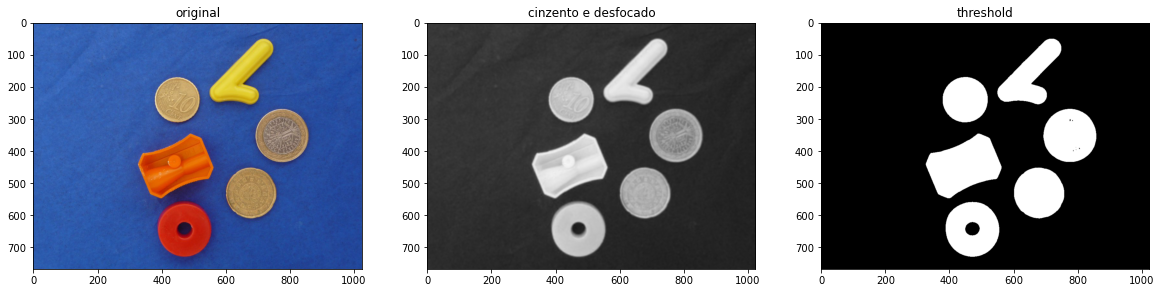

In [42]:
# Tornar a imagem recebida numa binária, de onde se podem notar os contornos das moedas
def TurnBin(nomeImg, teste=False):
    imgOriginal = cv2.imread(nomeImg)
    
    # O desfoque gausseano ajuda a que os contornos definidos pelos detalhes 
    # das moedas se tornem menos evidentes, dando um melhor resultado na 
    # imagem de threshold. Para um resultado poder ser considerado perto
    # de ótimo, não se devem notar estes ditos detalhes.
    # Na fase de teste (acima) usou-e um kernel de (5x5) neste filtro, e no
    # resultado obtido ainda se notam alguns contornos, para contrariar isto 
    # e  efetivamente melhorar o resultado, aumentou-se o kernel para uma 
    # janela de (9x9)
    imgGrayBlur = cv2.GaussianBlur(imgOriginal[:,:,2],(9,9),0)  # isolar o canal vermelho
    # escolher o threashold de OTSU (passando como flag cv2.THRESH_OTSU)
    otsu_threshold, imgth = cv2.threshold(imgGrayBlur,0,255,cv2.THRESH_OTSU)
    
    # If de testes:  mostrar os resultados de cada passo
    if teste:
        print(nomeImg)
        plt.figure(figsize=(20,5))
        plt.subplot(131), plt.imshow(bgr2rgb(imgOriginal)), plt.title('original')
        plt.subplot(132), plt.imshow(bgr2rgb(imgGrayBlur)), plt.title('cinzento e desfocado')
        plt.subplot(133), plt.imshow(bgr2rgb(imgth)), plt.title('threshold'), plt.show()
        
    return imgth

# testar para 3 imagens (escolhidas com base nos objetos)
for i in ['P1000705s.jpg','P1000709s.jpg','P1000710s.jpg']:
    TurnBin(i, teste=True)

<a id='section4'></a>
### Melhoramento da imagem
[indice](#section0) [prev](#section3) [next](#section5)

Para a extração de características, concodámos que a característica a ser usada para valor de caratacerização seria a área calculada para cada moeda.
Começamos por fazer um closing para preencher os buracos (zonas pretas) que ainda se encontrem dentro das moedas.

No entanto coloca-se um problema: há moedas que estão demasiado juntas (tocam-se), o que faz com que o contorno em vez de ser um circulo claro para cada moeda, se torna uma figura em forma de "8". Queremos então conseguir separar as moedas nestes casos. Conseguimos fazer isto através da <u>erosão</u> da imagem. Adicionalmente, para voltar a ter uma forma mais parecida com um círculo, aplicámos um efeito de desfoque gausseano, eliminando os "braços" que as conectavam após a erosão.

O nosso parâmetro de erosão não teve de ser o mais preciso, visto que usamos a área calculada, não importa muito se uma moeda de 1 euro ficar do tamanho que a moeda de 1 cêntimo tinha originalmente, visto que depois dos efeitos aplicados, todas as moedas vão continuar com a mesma proporção erodida. Basta apenas certificar que o objeto <u>redondo</u> com um buraco no meio não ia desaparecer.

P1000705s.jpg


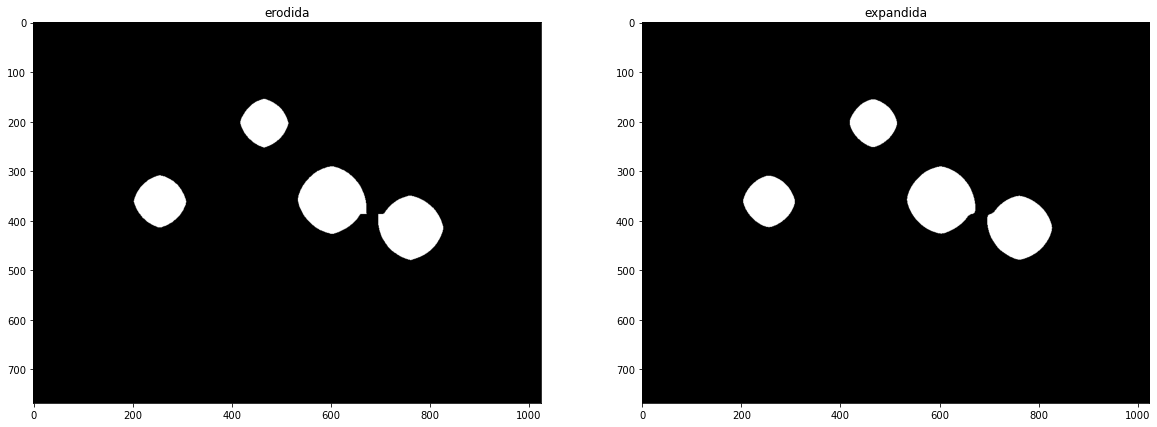

P1000709s.jpg


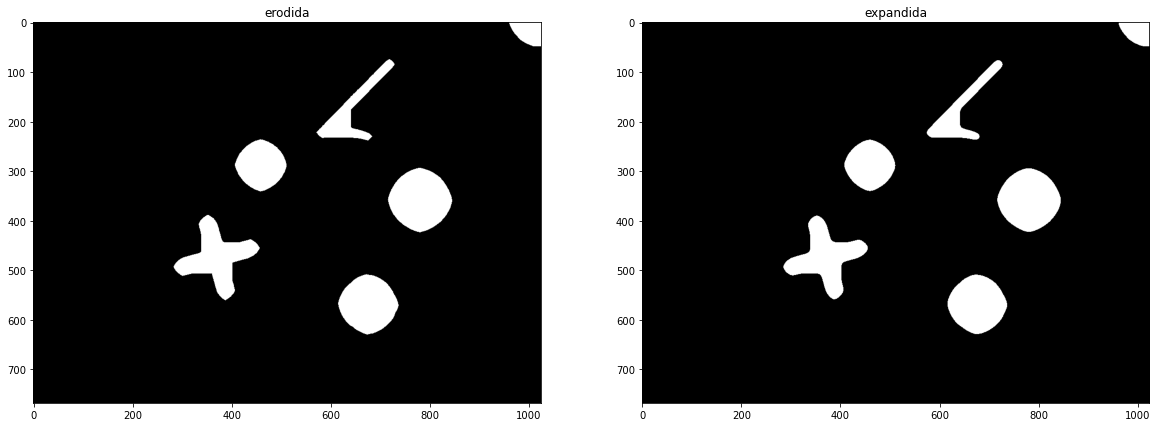

P1000710s.jpg


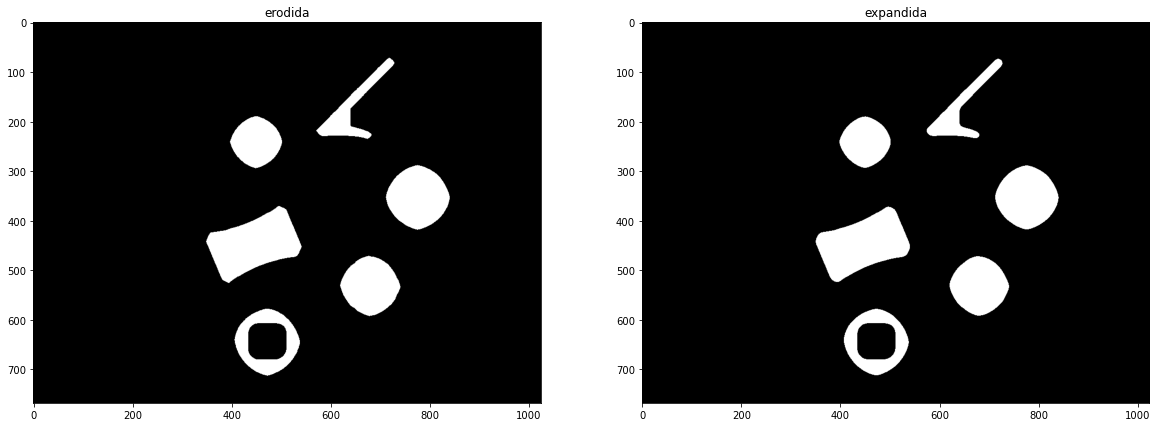

In [56]:
# melhoramento da imagem
def enhancedImage(img, teste=False):
    
    # Se em caso de teste, imprimir o nome da imagem, juntamente com
    # a realização do plot da imagem erodida, e posteriormente expandida
    if teste:
        print(img)
        img=TurnBin(img);
        img=(img/255).astype('uint8')
        
    # Para facilitar o processo de melhoramento, escolhemos como elemento
    # estruturante uma eliplse (por default os kernels são retangulres)
    # para estar mais de acordo com o formato das moedas.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
    # o closing é o mesmo que realizar uma dilatação seguida por uma erosão
    # com o objetivo de fechar pequenos "buracos" que se encontrem nos
    # objetos.
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    # As imagens até aqui podem ter presentes um "braço" que liga moedas
    # que se toquem. Para remover este braço, são feitas erosões sobre
    # a imagem até que desapareçam. Usou-se um canal mais pequeno (3x3)
    # visto que os braços eram fininhos, e não era justificavel usar
    # uma janela muito maior.
    # O valor das iterações foi com base em vários cenários de teste,
    # que nos levaram a optar por este número (16)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    img = cv2.erode(img,kernel,iterations = 16)
    
    # em situação de teste, mostrar as imagens
    if teste:
        img0 = img.copy()
        img1 = cv2.GaussianBlur(img,(9*3,9*3),0)
        
        plt.figure(figsize=(20,15))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor((img0*255).astype('uint8'), cv2.COLOR_BGR2RGB)), plt.title('erodida')
        plt.subplot(122)
        plt.imshow(cv2.cvtColor((img1*255).astype('uint8'), cv2.COLOR_BGR2RGB)), plt.title('expandida'), plt.show()
        
        return img0, img1
    
    # em situação de uso da função, retornar a imagem com um desfoque para
    # aproximar os contornos a uma forma mais redonda
    else:
        return cv2.GaussianBlur(img,(9*3,9*3),0)

# testes
for i in ['P1000705s.jpg','P1000709s.jpg','P1000710s.jpg']:
    enhancedImage(i, teste=True)

<a id='section5'></a>
### Extração de componentes conexos
[indice](#section0) [prev](#section4) [next](#section6)

Para encontrar os contornos é usado o argumento **RETR_TREE** como modo de obtenção de contornos.
Para os casos de haver formas dentro de outras formas, a figura mais exterior é vista como <u>parente</u> e a interior como <u>filho</u>. Desta forma os contornos numa imagem são criados com um tipo de 'relação' entre eles. Podemos especificar se um contorno é filho de outro  através da hierarquia criada.

Nesta função ao usarmos o argumento *RETR_TREE* ficamos com uma hierarquia que devolve todos os contornos, avaliamos os últimos 2 índices de cada contorno, que indicam se o contorno contem um *filho* ou um *parente*. Se isto se verificar, podemos excluir estes contornos. Efetivamente eliminados objetos que tenham buracos (como o objeto em forma de "donut").

In [61]:
def seeParentChild(array,index):
    if((array[0][index][3] != -1) or (array[0][index][2] != -1)):
        return True

<a id='section6'></a>
### Definição de caracteristicas
[indice](#section0) [prev](#section5) [next](#section7)

A nossa definição de característica é feita através da área calculada, como já foi referido previamente. Esta área é calculana na [alínea abaixo](#section7). Durante a fase de teste anotámos à mão os valores que cada moeda registava e através de uma aproximação desses valores atribuímos um desvio que não criasse colisões ou sobreposições com os tamanhos/áreas das outras moedas. Isto apenas foi possível porque o ambiente de teste é um ambiente controlado, sem grande variações (seja de luz, angulo ou distância).

Para a moeda de 2 euros, que vai ser usada na fase de avaliação por parte do docente a fim de testar a efetividade do trabalho realizado, foi realizada uma estimativa do valor da sua área. Esta área tem de ser **maior** que a moeda de 50 cêntimos (a maior moeda da coleção usada para teste).

Esta função vai ser usada no método que faz toda a avaliação e atribuição de valores às moedas.

In [62]:
# Os ifs estão por ordem de valor das moedas, mas se estivessem por ordem
# de área calculada seria:
# - 0,01€ (1 centimo)   -> menor
# - 0,02€ (2 centimos)
# - 0,10€ (10 centimos)
# - 0,05€ (5 centimos)
# - 0,20€ (20 centimos)
# - 1€    (1 euro)
# - 0,50€ (50 centimos)
# - 2€    (2 euros)     -> maior

def getMoneyByCoinArea(area):
    
    if (3500. <= area <= 4500.):
        return "1 centimo", 0.01
    
    elif(6300. <= area <= 6800.):
        return "2 centimos", 0.02
    
    elif(8500. <= area <= 9200.):
        return "5 centimos", 0.05
    
    elif(7250. <= area <= 7900.):
        return "10 centimos", 0.10
    
    elif(10000. <= area <= 11000.):
        return "20 centimos", 0.20
    
    elif(13000. <= area <= 13950.):
        return "50 centimos", 0.50
    
    elif(11500. <= area <= 12100.):
        return "1 euro", 1.00
    
    elif(14000. <= area <= 15000.):
        return "2 euros",2.00
    else:
        return "Nao e moeda", 0

<a id='section7'></a>
### Extração de propriedades
[indice](#section0) [prev](#section6) [next](#section8)

Esta última função, e fase final do trabalho, é onde é feita a extração de propriedades de cada moeda, assim como a atribuição dos seus devidos valores.

A função recebe o nome da imagem a ser lida (para este efeito, a imagem deve estar na diretoria deste ficheiro, ou deve ser recebido o path até à imagem). 
É calculada a imagem binária (método *TurnBin()*), que como trabalha com imagens com valores entre 0-255, retorna imagens com 0 ou 255 atribuidos a cada pixel (preto e branco respetivamente). Para ficarmos verdadeiramente com uma imagem binária (valores 0 ou 1), é feita uma divisão por 255, assim se um pixel tiver o valor 0, este mantém-se, mas se tiver o valor 255, este passa a 1.

Segue-se o cálculo dos contornos (*countours*) e as suas hierarquias (*hierarchy*). As variáveis **ncirculo** e **scirculo** são utilizadas para a contabilização de que contornos correspondem a um objeto e não a um circulo, e os que são efetivamente circulos. A variável **money** é a variável que vai guardar o valor das moedas na imagem, ou seja, é a variável à qual vão sei adicionados os valores obtidos para cada moeda encontrada.

Para cada contorno são calculadas as seguinte propriedades:
- área
- perímetro
- circularidade
- raio

Adicionalmente, procurámos também encontrar o *centro* de cada contorno.

Para avaliar se um contorno é, ou não, um <u>círculo</u>, utilizou-se a <u>circularidade</u> calculada => aqui definiu-se que qualquer contorno que tenha uma circularidade inferior a **80%** é definido como **nada**, ou seja, não é de interesse para este classificador.\
Com os círculos detetados, restou detetar quais dos contornos têm um buraco no meio, sendo que no conjunto de teste foi usado, para além de moedas (sem buracos), um objeto com esta característica, para afinar o classificador. Como solução usou-se a função criada *seeParentChild()* para excluir do conjunto de objetos encontrados os contornos com filhos (ou seja, buracos). Estes objetos recebem o nome de "donut".

In [66]:
def coinDetect(img, prints=True):
    
    # leitura da imagem recebida
    imgOriginal = cv2.imread(img) # ler imagem pelo nome/path recebido
    img = TurnBin(img) # tornar a imagem na sua forma binaria
    img = (img/255).astype('uint8') # /255 para ficarmos com valores 0 ou 1
    img = enhancedImage(img) # melhoramento da imagem

    # calcular contornos
    contours,hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ncirculo = 1 # não é circulo
    scirculo = 1 #     é circulo
    money = 0.00 # valor total monetário
    i=0
    
    # Para cada contorno:
    for contour in contours:
        
        # calculo de: area, perimetro, circulatidade, raio
        area = cv2.contourArea(contour)
        arclength = cv2.arcLength(contour, True);
        circularity = 4 * np.pi * area / (arclength * arclength);
        radius = np.sqrt(arclength / np.pi)
        
        # calculo de: centro do contorno (media da area que ocupa os pixeis 
        # do contorno)
        # Detetar os momentos de cada contorno: os momentos de uma imagem 
        # ajudam ao calculo das características calculadas. Neste caso 
        # utilizou-se para encontrar o centro de cada contorno
        M = cv2.moments(contour)
        if M['m00'] != 0.0:
            x = int(M['m10']/M['m00'])
            y = int(M['m01']/M['m00'])
        
        # Determinar o objeto:
        # circularidade > 0.8 + com relações => donut
        # circularidade < 0.8 => nada
        # circularidade > 0.8 + sem relações => moeda
        # Para cada objeto, colocar na imagem a identificação calculada, e
        # imprimir as suas características.
        
        # Se tiver circularidade acima de 80%, mas tiver parente/filhos
        # => donut
        if((circularity > 0.8) and (seeParentChild(hierarchy,i))):
            cv2.putText(imgOriginal,'donut',(x, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2 ,cv2.LINE_AA)
            if prints:
                print("donut: {}".format(ncirculo))
                print('Area: {} ArcLength: {} Circularidade: {} Radius: {}\n'.format(area,arclength,circularity,radius))
            ncirculo += 1
        
        # Se tiver circularidade inferior a 80%
        # => nada
        elif((circularity < 0.8)):
            cv2.putText(imgOriginal,'nada',(x, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2 ,cv2.LINE_AA)
            if prints:
                print("nao é moeda: {}".format(ncirculo))
                print('Area: {} ArcLength: {} Circularidade: {}\n'.format(area,arclength,circularity))
            ncirculo += 1
            
        # Se tiver circularidade acima de 80%, sem parente/filhos
        # => moeda
        else:
            cv2.putText(imgOriginal, "{}".format(getMoneyByCoinArea(area)[0]),(x, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2 ,cv2.LINE_AA)
            #cv2.putText(imgOriginal, "{}".format(area),(x, y+40),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2 ,cv2.LINE_AA)
            money = money + getMoneyByCoinArea(area)[1]
            if prints:
                print("circulo: {} => {}".format(scirculo,getMoneyByCoinArea(area)[0]))
                print('Area: {} ArcLength: {} Circularidade: {} Radius: {}\n'.format(area,arclength,circularity,radius))
            scirculo += 1
        i +=1    
    
    # Colocar na imagem o valor total calculado para as moedas encontradas
    cv2.putText(imgOriginal,"Total Money: {}".format(round(money,2)), (50,50),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2 ,cv2.LINE_AA)
    
    # voltar a colocar imagem de contornos com valores entre 0 e 255 para plot
    img = (img*255).astype('uint8')

    return img, imgOriginal

<a id='section8'></a>
### Resultados
[indice](#section0) [prev](#section7) [next](#section9)

circulo: 1 => 1 euro
Area: 11675.0 ArcLength: 407.2447293996811 Circularidade: 0.8846180744328501 Radius: 11.385518146494745

circulo: 2 => 20 centimos
Area: 10411.0 ArcLength: 386.7594475746155 Circularidade: 0.8746221022100207 Radius: 11.095465548501407

circulo: 3 => 1 centimo
Area: 3943.5 ArcLength: 237.66399431228638 Circularidade: 0.8773339298343019 Radius: 8.697746776006356

circulo: 4 => 10 centimos
Area: 7417.5 ArcLength: 325.4041095972061 Circularidade: 0.8802810486635902 Radius: 10.17739382600597

circulo: 5 => 2 centimos
Area: 6550.5 ArcLength: 305.26197385787964 Circularidade: 0.8833623778061902 Radius: 9.857378158259982



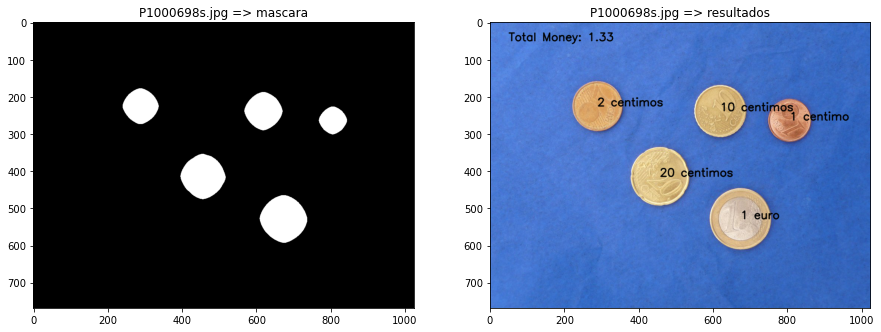

circulo: 1 => 20 centimos
Area: 10396.5 ArcLength: 385.3452332019806 Circularidade: 0.8798265024949896 Radius: 11.075161277470803

circulo: 2 => 5 centimos
Area: 8840.0 ArcLength: 354.1320323944092 Circularidade: 0.8857919013177867 Radius: 10.617143067958484

circulo: 3 => 1 centimo
Area: 3926.0 ArcLength: 236.24978065490723 Circularidade: 0.8839288959267948 Radius: 8.671830302260823

circulo: 4 => 2 centimos
Area: 6495.0 ArcLength: 304.6761863231659 Circularidade: 0.8792492322670582 Radius: 9.84791562674246

circulo: 5 => 50 centimos
Area: 13296.5 ArcLength: 433.9726504087448 Circularidade: 0.8872019361844241 Radius: 11.75320317864392



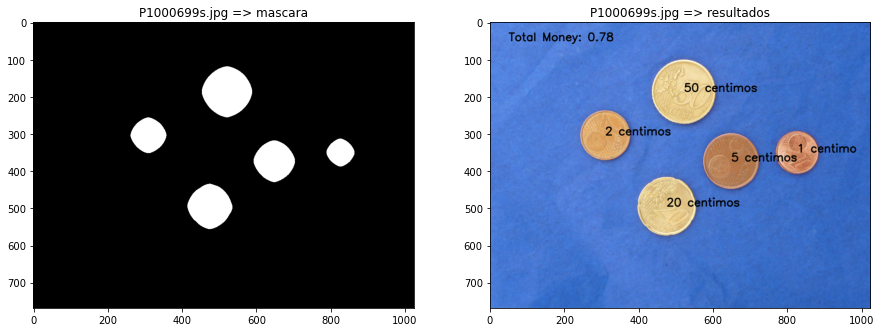

nao é moeda: 1
Area: 16525.0 ArcLength: 563.7300096750259 Circularidade: 0.653444975227259

circulo: 1 => 5 centimos
Area: 8796.0 ArcLength: 354.960457444191 Circularidade: 0.8772737488670487 Radius: 10.629554214961543

circulo: 2 => 10 centimos
Area: 7426.5 ArcLength: 325.4041085243225 Circularidade: 0.8813491406820182 Radius: 10.177393809228125

circulo: 3 => 2 centimos
Area: 6481.5 ArcLength: 304.0904006958008 Circularidade: 0.8808053982307125 Radius: 9.83844402510192

circulo: 4 => 50 centimos
Area: 13268.5 ArcLength: 433.9726496934891 Circularidade: 0.8853336538989016 Radius: 11.753203168958349



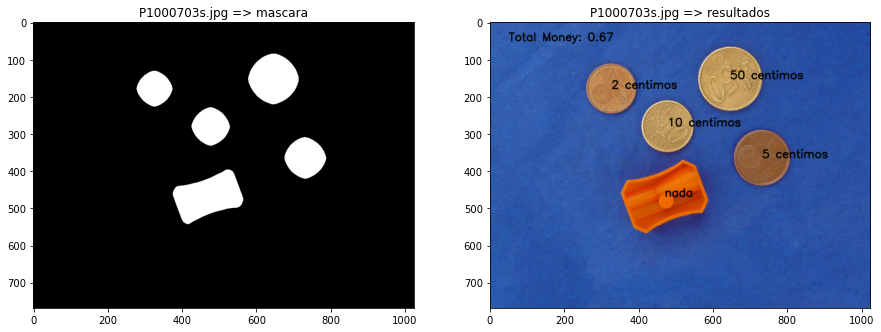

circulo: 1 => 1 euro
Area: 11894.5 ArcLength: 414.65894198417664 Circularidade: 0.8693086162381126 Radius: 11.48869185887037

circulo: 2 => 10 centimos
Area: 7580.5 ArcLength: 328.2325358390808 Circularidade: 0.8841876816134795 Radius: 10.221529294814687

circulo: 3 => 50 centimos
Area: 13210.5 ArcLength: 436.80107867717743 Circularidade: 0.8700850669844413 Radius: 11.791441881241214

circulo: 4 => 2 centimos
Area: 6389.0 ArcLength: 301.84775972366333 Circularidade: 0.8811844776538413 Radius: 9.802098042892219



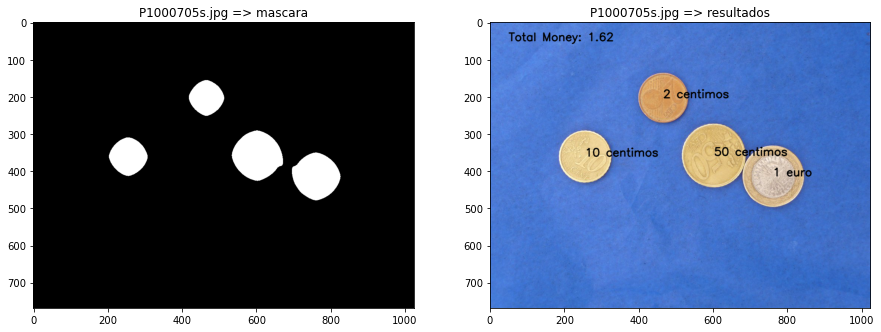

circulo: 1 => 1 euro
Area: 11834.5 ArcLength: 409.83051466941833 Circularidade: 0.8854238072925044 Radius: 11.421606913174122

circulo: 2 => 10 centimos
Area: 7590.0 ArcLength: 328.8183227777481 Circularidade: 0.8821442758256289 Radius: 10.230646260062457

circulo: 3 => 5 centimos
Area: 8993.5 ArcLength: 360.2325360774994 Circularidade: 0.8709089062815694 Radius: 10.708201415668604

circulo: 4 => 2 centimos
Area: 6518.5 ArcLength: 307.9482650756836 Circularidade: 0.8637777452266695 Radius: 9.900655392787725

circulo: 5 => 50 centimos
Area: 13284.5 ArcLength: 433.9726496934891 Circularidade: 0.8864012454474853 Radius: 11.753203168958349



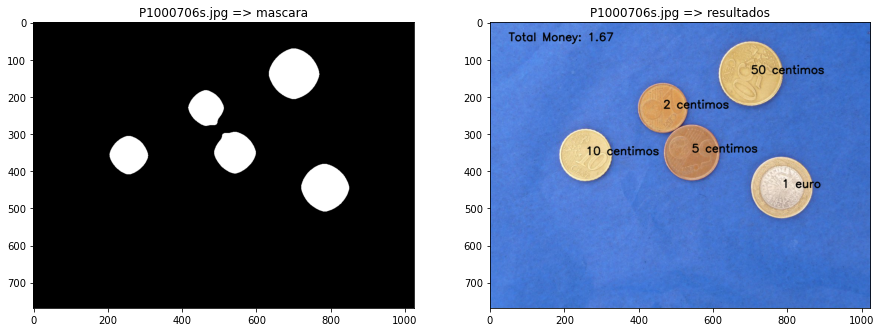

circulo: 1 => 20 centimos
Area: 10261.0 ArcLength: 382.2741656303406 Circularidade: 0.8823678047900386 Radius: 11.030940402014565

nao é moeda: 1
Area: 10983.5 ArcLength: 604.3157966136932 Circularidade: 0.37793988359126013

circulo: 2 => 1 euro
Area: 11761.5 ArcLength: 409.002086520195 Circularidade: 0.8835304666431618 Radius: 11.410057300871726

circulo: 3 => 10 centimos
Area: 7472.0 ArcLength: 326.81832253932953 Circularidade: 0.8790912030054623 Radius: 10.199485430661262

nao é moeda: 2
Area: 5750.0 ArcLength: 547.3523812294006 Circularidade: 0.24118132964021144

nao é moeda: 3
Area: 2278.0 ArcLength: 200.0832600593567 Circularidade: 0.715059323746342



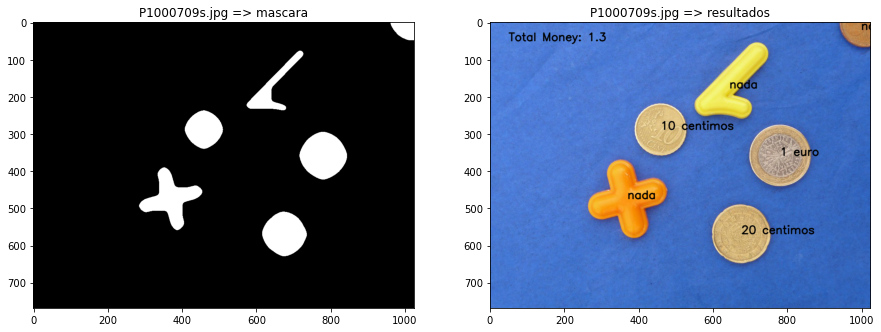

donut: 1
Area: 12557.5 ArcLength: 422.315797328949 Circularidade: 0.8847863145998592 Radius: 11.594278476101673

donut: 2
Area: 5292.0 ArcLength: 271.19595861434937 Circularidade: 0.9041974394397405 Radius: 9.291090071678218

circulo: 1 => 20 centimos
Area: 10153.5 ArcLength: 380.5168068408966 Circularidade: 0.8812070233400902 Radius: 11.005555936732376

nao é moeda: 3
Area: 16350.5 ArcLength: 565.771639585495 Circularidade: 0.641886961995264

circulo: 2 => 1 euro
Area: 11740.0 ArcLength: 409.2447280883789 Circularidade: 0.8808699077826547 Radius: 11.4134413223676

circulo: 3 => 10 centimos
Area: 7511.5 ArcLength: 327.40410935878754 Circularidade: 0.880578917305702 Radius: 10.208622080677737

nao é moeda: 4
Area: 5636.5 ArcLength: 548.7665942907333 Circularidade: 0.23520364238633304



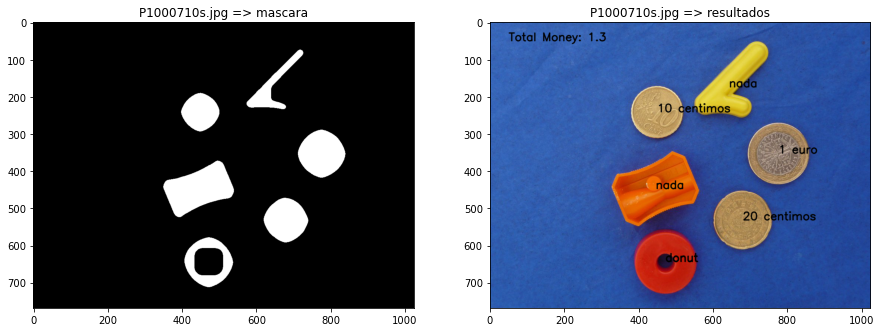

circulo: 1 => 20 centimos
Area: 10602.5 ArcLength: 393.8893891572952 Circularidade: 0.8587555993733975 Radius: 11.197271392248268

circulo: 2 => 50 centimos
Area: 13318.0 ArcLength: 440.27416718006134 Circularidade: 0.8633809582015023 Radius: 11.838227065095033

circulo: 3 => 1 euro
Area: 11958.0 ArcLength: 412.0731567144394 Circularidade: 0.8849520993696036 Radius: 11.452814484360102

donut: 1
Area: 12581.5 ArcLength: 422.80107939243317 Circularidade: 0.8844435339706691 Radius: 11.600938042235605

donut: 2
Area: 5215.0 ArcLength: 270.3675310611725 Circularidade: 0.8965099344371086 Radius: 9.276888381341792



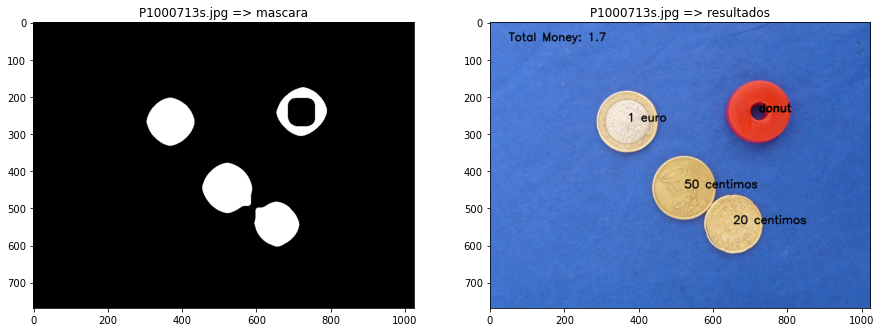

In [77]:
# ficheiros a serem testados
ficheirosNomes = [
'P1000698s.jpg',
'P1000699s.jpg',
'P1000703s.jpg',
'P1000705s.jpg',
'P1000706s.jpg',
'P1000709s.jpg',
'P1000710s.jpg',
'P1000713s.jpg'
]

# para cada ficheiro realizar a deteção e imprimir resultados obtidos
for i in range(len(ficheirosNomes)):
    binary, image = coinDetect(ficheirosNomes[i])
    plt.figure(figsize=(15,10))
    plt.subplot(121), plt.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB)), plt.title('{} => mascara'.format(ficheirosNomes[i]))
    plt.subplot(122), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('{} => resultados'.format(ficheirosNomes[i]))
    plt.show()

<a id='section9'></a>
### Bibliografia
[indice](#section0) [prev](#section8) [next](#section10)

https://docs.opencv.org/3.4/d4/d76/tutorial_js_morphological_ops.html

https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-3-otsu-thresholding/

https://www.geeksforgeeks.org/how-to-detect-shapes-in-images-in-python-using-opencv/

***
<a id='section10'></a>
### Zona de testes adicionais para o docente
[indice](#section0) [prev](#section9)

Para esta seccão criámos 2 funções para melhor facilitar o teste:
1. [testar_imagem()](#testar1) => testa uma única imagem
2. [testar_imagens()](#testarVarias) => testa um array de imagens

A primeira recebe como argumentos: **nome da imagem+extensão** e um **False** para não se imprimir  a informação calculada (se este valor estiver em True, são mostradas as informações de cada circulo).

A segunda recebe um <u>array</u> com os nomes das imagens, no mesmo formato que a anterior, e mostra para cada imagem introduzida, o resultado.

É feito um exemplo abaixo, pelo que basta ao docente mudar o nome dos ficheiros a serem testados.

<a id='testar1'></a>
### <span style="color:#963727">----- TESTAR 1 IMAGEM -----</span>
[indice](#section0)\
[testar várias imagens](#testarVarias)

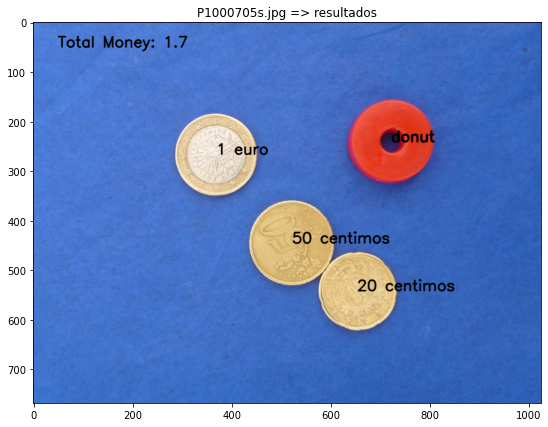

In [81]:
def testar_imagem(nome_imagem, prints=False):
    binary, image = coinDetect(ficheirosNomes[i], prints)
    plt.figure(figsize=(13,7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title(f'{nome_imagem} => resultados')
    plt.show()
    
# imagem a testar: MUDAR AQUI
imagem = 'P1000705s.jpg'

# testar COM ou SEM informações
testar_imagem(imagem)
# testar_imagem(imagem, True) # com informacoes

<a id='testarVarias'></a>
### <span style="color:#963727">----- TESTAR VÁRIAS IMAGENS -----</span>
[indice](#section0)\
[testar 1 imagem](#testar1)

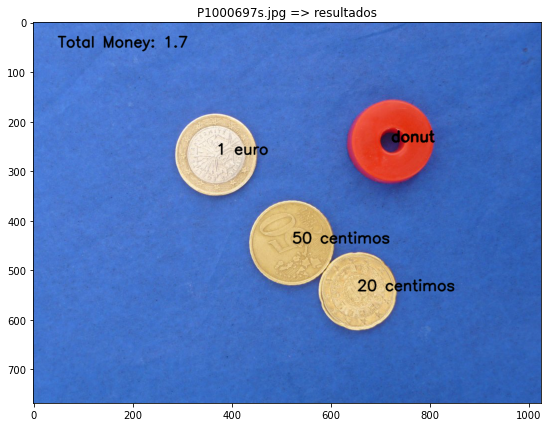

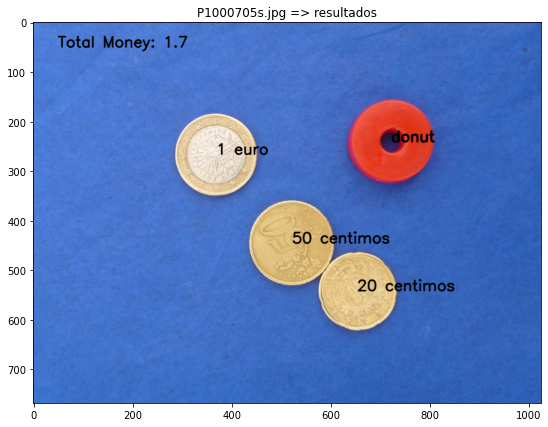

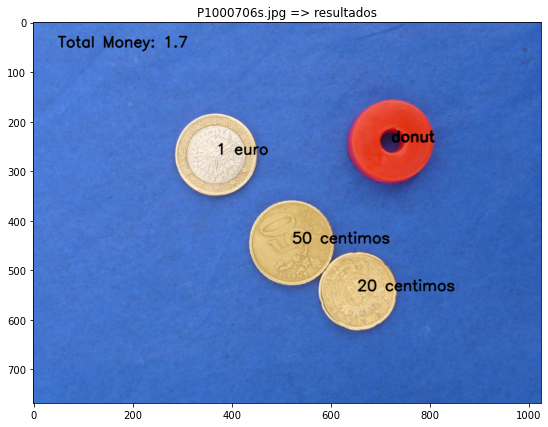

In [82]:
def testar_imagens(array_imagens, prints=False):
    for i in array_imagens:
        testar_imagem(i,prints)

# imagens a testar: MUDAR AQUI
imagensNomes = [
    "P1000697s.jpg",
    "P1000705s.jpg",
    "P1000706s.jpg"
]

# testar COM ou SEM informações
testar_imagens(imagensNomes)
#testar_imagens(imagensNomes, True) # com informacoes